##### Copyright 2019 The TensorFlow Authors.

# Environment setup

In [1]:
# connect to google drive
from google.colab import drive

drive.mount('/gdrive')
gdrive_root = '/gdrive/My Drive'
gdrive_data = '/gdrive/My Drive/my_data'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [2]:
# import libraries
from __future__ import absolute_import, division, print_function, unicode_literals

!pip install tensorflow-gpu==2.0.0
import tensorflow as tf

import numpy as np
import os
import time

     |████████████████████████████████| 380.8MB 46kB/s 
     |████████████████████████████████| 450kB 49.3MB/s 
     |████████████████████████████████| 3.8MB 31.3MB/s 
     |████████████████████████████████| 81kB 11.0MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.1 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorboard 2.0.1 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.6.3 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled goog

# Data preprocessing + dataset construction

1554 protein sequences with antimicrobial property (AMP)

Source: https://github.com/alexarnimueller/LSTM_peptides

In [3]:
# import dataset
import urllib
urllib.request.urlretrieve("https://drive.google.com/uc?export=download&id=1PJKo1F_JLdBL_ACsEpuHWt6Fj4mLZ7fv", "peptides.csv")
!ls peptides.csv

# show example
text = open('peptides.csv', 'rb').read().decode(encoding='utf-8')
print("\n"+text[:250]) # line-separated
print("\n"+repr(text[:250])+"\n") # include carriage return and newline characters

# make vocabulary
vocab = sorted(set(text))
vocab.append('<sos>')
print(vocab)
print('\n{} unique characters'.format(len(vocab)))

peptides.csv

SLGGFLKGVGKALAGVGKMVADQFGNLLQAGQ
FALLGDFFRKSKEKIGKEFKRIVQRIKDFLRNLVPRTES
KQIKMKLREMVLFT
FIGAIARLLSKIF
KPPAWVP
GLFKTLIKGAGKMLGHVAKQFLGSQGQPES
GMASLLAKVLPHVVKLIK
FLLSLPHLASGLASLVLSK
LLGDFFRKSKEKIGKEFKRIVQR
LLGDLLRKSKEKIGKEFKRIVQRIKDFLRNLVPRTES

'SLGGFLKGVGKALAGVGKMVADQFGNLLQAGQ\r\nFALLGDFFRKSKEKIGKEFKRIVQRIKDFLRNLVPRTES\r\nKQIKMKLREMVLFT\r\nFIGAIARLLSKIF\r\nKPPAWVP\r\nGLFKTLIKGAGKMLGHVAKQFLGSQGQPES\r\nGMASLLAKVLPHVVKLIK\r\nFLLSLPHLASGLASLVLSK\r\nLLGDFFRKSKEKIGKEFKRIVQR\r\nLLGDLLRKSKEKIGKEFKRIVQRIKDFLRNLVPRTES'

['\n', '\r', 'A', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', '<sos>']

22 unique characters


In [4]:
# char<->int mapping
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

# show mapping
print('{')
for char,_ in zip(char2idx, range(15)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

# string -> numpy array
def encode(text, char2idx):
  return(np.array([char2idx[c] for c in text]))

# sequence mapping example
temp_text = repr(text[:20])[1:-1]
temp_int = encode(temp_text,char2idx)
print('{} -> {}'.format(temp_text, temp_int))

{
  '\n':   0,
  '\r':   1,
  'A' :   2,
  'D' :   3,
  'E' :   4,
  'F' :   5,
  'G' :   6,
  'H' :   7,
  'I' :   8,
  'K' :   9,
  'L' :  10,
  'M' :  11,
  'N' :  12,
  'P' :  13,
  'Q' :  14,
  ...
}
SLGGFLKGVGKALAGVGKMV -> [16 10  6  6  5 10  9  6 18  6  9  2 10  2  6 18  6  9 11 18]


In [5]:
# determine max sequence length
text = open('peptides.csv', 'r',encoding='utf-8')
max_len = 0
data_list = []

# iterate
for line in text:
  data_list.append(line[:-1])
  max_len = max(max_len,len(line))
  
print("max seq length = " + str(max_len))

max seq length = 49


In [0]:
import random

# construct dataset
text = open('peptides.csv', 'r',encoding='utf-8')

dataset = []
for line in text:
  # encode to integers
  seq = encode(line, char2idx)
  
  # pad with <eos>
  pad = np.zeros((max_len - seq.shape[0]))

  # prefix with <sos>(unused in vocab) and add to dataset
  dataset.append(tf.convert_to_tensor(np.concatenate(([len(vocab)-1], seq, pad)), dtype=tf.int32))

# construct keras dataset
dataset = tf.data.Dataset.from_tensor_slices(dataset)

# split input and target
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

# apply split
dataset = dataset.map(split_input_target)

In [7]:
# show example
for input_example, target_example in dataset.take(1):
  print("input seq = " + str(input_example.numpy()))
  print("target = " + str(target_example.numpy()))

# show inference target example
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print("{:4d}단계".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  target output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

input seq = [21 16 10  6  6  5 10  9  6 18  6  9  2 10  2  6 18  6  9 11 18  2  3 14
  5  6 12 10 10 14  2  6 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0]
target = [16 10  6  6  5 10  9  6 18  6  9  2 10  2  6 18  6  9 11 18  2  3 14  5
  6 12 10 10 14  2  6 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0]
   0단계
  input: 21 ('<sos>')
  target output: 16 ('S')
   1단계
  input: 16 ('S')
  target output: 10 ('L')
   2단계
  input: 10 ('L')
  target output: 6 ('G')
   3단계
  input: 6 ('G')
  target output: 6 ('G')
   4단계
  input: 6 ('G')
  target output: 5 ('F')


In [8]:
# make minibatches
BATCH_SIZE = 4
BUFFER_SIZE = 10000

# shuffle and slice
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((4, 49), (4, 49)), types: (tf.int32, tf.int32)>

# Sequence model architecture: 2-layer LSTM

- embedding layer (256 units)
- LSTM layer (256 units)
- dropout layer (rate=0.2)
- LSTM layer (256 units)
- dropout layer (rate=0.4)
- FC prediction layer

In [0]:
# set model capacity
vocab_size = len(vocab)
embedding_dim = 256
rnn_units = 256

In [0]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
    tf.keras.layers.LSTM(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.LSTM(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dropout(rate=0.4),
    tf.keras.layers.Dense(vocab_size)
  ])
  return model

In [0]:
# build model
model = build_model(
  vocab_size=len(vocab),
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE)

In [12]:
# check batch prediction dimension
for input_example_batch, target_example_batch in dataset.take(1):
  example_batch_predictions = model(input_example_batch)
  print("prediction tensor shape: " + str(example_batch_predictions.shape))

model.summary()

# show 1 example from a batch
# multinomial sampling from predicted distribution
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()
sampled_indices

print("input: \n", repr("".join(idx2char[input_example_batch[0]])))
print()
print("sampled prediction: \n", repr("".join(idx2char[sampled_indices])))

prediction tensor shape: (4, 49, 22)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (4, None, 256)            5632      
_________________________________________________________________
lstm (LSTM)                  (4, None, 256)            525312    
_________________________________________________________________
dropout (Dropout)            (4, None, 256)            0         
_________________________________________________________________
lstm_1 (LSTM)                (4, None, 256)            525312    
_________________________________________________________________
dropout_1 (Dropout)          (4, None, 256)            0         
_________________________________________________________________
dense (Dense)                (4, None, 22)             5654      
Total params: 1,061,910
Trainable params: 1,061,910
Non-trainable params: 0
_________

# Training

- loss: cross-entropy
- optimizer: Adam
- learning rate: 1e-3
- training epochs: 40
- minibatch size: 4

training loss vs. epoch

<div>
<img src=https://drive.google.com/uc?export=download&id=1DOiK3NS-5-eEnM3tfkj2br3ROrmIX_Sz height="300"/>
</div>

In [13]:
# define loss
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

# show example
example_batch_loss  = loss(target_example_batch, example_batch_predictions)
print("예측 배열 크기(shape): ", example_batch_predictions.shape, " # (배치 크기, 시퀀스 길이, 어휘 사전 크기")
print("스칼라 손실:          ", example_batch_loss.numpy().mean())

예측 배열 크기(shape):  (4, 49, 22)  # (배치 크기, 시퀀스 길이, 어휘 사전 크기
스칼라 손실:           3.0882854


In [0]:
# set model-saving checkpoints
checkpoint_dir = gdrive_data+'/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [15]:
# train the model
EPOCHS = 40

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss=loss)

history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback], verbose=1)

Epoch 1/40
388/388 [==============================] - 23s 59ms/step - loss: 1.2330
Epoch 2/40
388/388 [==============================] - 17s 44ms/step - loss: 1.0729
Epoch 3/40
388/388 [==============================] - 17s 43ms/step - loss: 0.9109
Epoch 4/40
388/388 [==============================] - 17s 43ms/step - loss: 0.8063
Epoch 5/40
388/388 [==============================] - 17s 43ms/step - loss: 0.7366
Epoch 6/40
388/388 [==============================] - 16s 42ms/step - loss: 0.6739
Epoch 7/40
388/388 [==============================] - 16s 42ms/step - loss: 0.6169
Epoch 8/40
388/388 [==============================] - 16s 42ms/step - loss: 0.5696
Epoch 9/40
388/388 [==============================] - 16s 42ms/step - loss: 0.5268
Epoch 10/40
388/388 [==============================] - 16s 42ms/step - loss: 0.4894
Epoch 11/40
388/388 [==============================] - 16s 42ms/step - loss: 0.4600
Epoch 12/40
388/388 [==============================] - 16s 41ms/step - loss: 0.4319
E

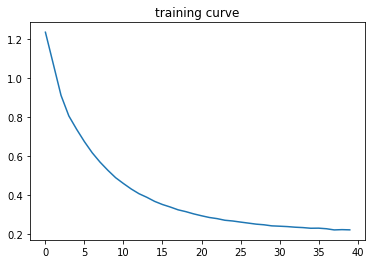

In [16]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.title('training curve')
plt.show()

# Inference (generation) with constraint

1000 new sequences sampled within constraint:
- Length between [7,48]
- Not already in training dataset
- Each sequence unique

Output .txt: FASTA format


In [17]:
# load checkpoint
tf.train.latest_checkpoint(checkpoint_dir)

'/gdrive/My Drive/my_data/training_checkpoints/ckpt_40'

In [18]:
# build model that processes 1 example at a time
# import trained weights
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (1, None, 256)            5632      
_________________________________________________________________
lstm_2 (LSTM)                (1, None, 256)            525312    
_________________________________________________________________
dropout_2 (Dropout)          (1, None, 256)            0         
_________________________________________________________________
lstm_3 (LSTM)                (1, None, 256)            525312    
_________________________________________________________________
dropout_3 (Dropout)          (1, None, 256)            0         
_________________________________________________________________
dense_1 (Dense)              (1, None, 22)             5654      
Total params: 1,061,910
Trainable params: 1,061,910
Non-trainable params: 0
____________________________________________

In [0]:
def generate_text(model, temperature):
  # start inference from <sos> token
  input_eval = [len(vocab)-1]
  input_eval = tf.expand_dims(input_eval, 0)

  text_generated = []

  # batch size 1
  # initialize hidden states
  model.reset_states()

  # max length = 48
  for i in range(48):
      predictions = model.predict(input_eval)
      predictions = tf.squeeze(predictions, 0)

      # sample next token from inferred multimodal probability distribution
      predictions = predictions / temperature
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

      # stop if <sos> or <eos> token is predicted
      if ((predicted_id == 0) or (predicted_id == len(vocab)-1)): break

      # feed previous output + sampled token + current hidden state to the model
      input_eval = tf.expand_dims([predicted_id], 0)

      # text generated so far
      text_generated.append(idx2char[predicted_id])

  # final generated text
  return (''.join(text_generated))

In [20]:
# temperature: sampling parameter
# low: similar to argmax
# high: smoothened softmax
temperature = 0.5

# write generated sequences in FASTA format on .txt file
wf = open(gdrive_data+"/generated_seqs.txt", "w")
cnt = 1

# already-generated sequences
log = []

# generate 1000 sequences
while (cnt<=1000):
  # generate sequence
  seq = generate_text(model, temperature)

  # write only if length>=7 and not already in training nor generated data
  if ((len(seq)>=7) and (seq not in data_list) and (seq not in log)):
    # write in FASTA format
    print(">seq_"+str(cnt)+"\n"+seq)
    wf.write(">\n")
    wf.write(seq+"\n")
    cnt += 1
    # log
    log.append(seq)

wf.close()

>seq_1
GLASLAKKVAKGLAAHVAS
>seq_2
KWGWKHIGKVVGKAFKGIVQIAKDALN
>seq_3
LGAVLAGLPNIVSWIKQ
>seq_4
ALKAVAKGLA
>seq_5
LSLIPKIISSPLFKTLLSAVGSALSSSGEQ
>seq_6
LPVILGHLVSGLL
>seq_7
LPIALKALGKIL
>seq_8
IGTKIIGGLKTAVKGALKELASTYVN
>seq_9
ALKAAAKGLANEIADKIEKKLGQKILDQGKDTASR
>seq_10
LASLVGGLKGLIGKLL
>seq_11
LASLGRALGKLLADVAKQ
>seq_12
VGALASVAKGL
>seq_13
LGALAKLVPHIISWIKQ
>seq_14
LGALAKVLPHIVPVIKNAL
>seq_15
LGKILHSAGKFGQAFLGEIMKS
>seq_16
ASLAGALGKL
>seq_17
FLGPLVGGLLASLFGK
>seq_18
GLLGVLAKVAPHVVPAIKQAG
>seq_19
GLRKAGKAALKAAGKAALGAVSEAL
>seq_20
LGKILHSAGKGFGHIMNSI
>seq_21
GLFSIAKHVLPHVVPVIAEK
>seq_22
ALKAAVKLVAGL
>seq_23
LGALASLVKGLF
>seq_24
ALAKVAGLVGL
>seq_25
FLGPLIAGALSSLF
>seq_26
VGSILGVLAKPLIKKGQPE
>seq_27
LSTLGNLLDK
>seq_28
SIGKALGGVKKALAKELAATYQ
>seq_29
ALAGVGAGLDTLSRRR
>seq_30
VGALAVAGLPALISWIKQR
>seq_31
GRRSGSRFAKFLKKRRRKF
>seq_32
LGKLLSTAGKLFGQLLPKQPQ
>seq_33
GLLGVLGSIAKHVLPHVVPVIAEKL
>seq_34
LGKLLSTAGKLLGDLFKPKLQA
>seq_35
GLGSILGALGKLIANVLKPKTPAS
>seq_36
LGAVLKVLPSIVSLVKK
>seq_37
LGKILGGLAKV

# Evaluation with CAMP random forest classifier

Percentage of active sequences (1000 sampled): 84.7%  
Percentage of active sequences from reference model (~1700 sampled): 82%

Pseudo-probability distribution (our model / reference):  
<div>
<img src=https://drive.google.com/uc?export=download&id=1UgH9Xx7SY0z0O4MJ0VtLQZT2K7dNlI6g height="300"/>
<img src=https://drive.google.com/uc?export=download&id=1ACqIyRjGvmXh4094UI7pwc2TpWlF5VCU height="300"/>
</div>

References:  
AT Müller et al. "Recurrent Neural Network Model for Constructive Peptide Design"  
CAMPR3 database, http://www.camp3.bicnirrh.res.in/predict/

In [21]:
# get generated sequences and their analysis data
urllib.request.urlretrieve("https://drive.google.com/uc?export=download&id=1Q_s8QWqVCGeiBjh-IjXexq4Sbyknp5CO", "gen_seqs.txt")
urllib.request.urlretrieve("https://drive.google.com/uc?export=download&id=15CI5jkXYSxLCgoJ204nVe2FUZ6ZoRn4X", "eval_rf.csv")
!ls gen_seqs.txt eval_rf.csv

eval_rf.csv  gen_seqs.txt


In [22]:
# gen_seqs.txt: generated sequences
f = open("./gen_seqs.txt", "r")

seqs = [] # save as a list of strings
f.readline()

for (line) in f:
  seqs.append(line[:-1])
  f.readline()

print(str(len(seqs)) + " sequences imported")

1000 sequences imported


In [23]:
# eval_rf.csv: evaluation of generated sequences by random forest model
f = open("./eval_rf.csv", "r")

AMP_bool = [] # AMP/NAMP classification
PAMP = [] # predicted pseudo-probability
f.readline()

for (line) in f:
  read = line[:-1].split(',')
  AMP_bool.append(read[1] == 'AMP')
  PAMP.append(float(read[2]))

print(str(len(AMP_bool)) + " classifications imported")
print(str(len(PAMP)) + " probabilities imported")

1000 classifications imported
1000 probabilities imported


In [24]:
AMP_bool = np.array(AMP_bool)
PAMP = np.array(PAMP)
seqs = np.array(seqs)

# show percentage of active (AMP) sequences
n_seqs = seqs.shape[0]
n_amp = np.where(AMP_bool)[0].shape[0]
print("# generated sequences: " + str(n_seqs))
print("# active sequences: " + str(n_amp))
print("\nactive percentage: " + str(n_amp/n_seqs*100) + "%")
print("active percentage of reference model: 82%")

# generated sequences: 1000
# active sequences: 847

active percentage: 84.7%
active percentage of reference model: 82%


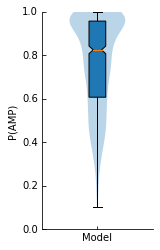

In [25]:
# plot pseudo-probabilities of sequences
from mpl_toolkits.axisartist.axislines import SubplotZero

fig = plt.figure(figsize=(2, 4), edgecolor='w')
ax = SubplotZero(fig, 1, 1, 1)
fig.add_subplot(ax)

for direction in ["right", "top"]:
    # hides borders
    ax.axis[direction].set_visible(False)

# overlaid violin and box plot
ax.violinplot(PAMP, showextrema=False)
ax.boxplot(PAMP, notch=True, patch_artist=True)

plt.ylim((0, 1))
plt.xticks([1],['Model'])
plt.ylabel("P(AMP)")
plt.show()